# Sentiment Analysis on Amazon Fine Food Reviews
### A Learning Portfolio Project by: Claire Lee Xiao Si

This notebook demonstrates NLP techniques for sentiment analysis using:
1. NLTK's VADER Sentiment Analyzer
2. RoBERTa Transformer Model
Dataset: Amazon Fine Food Reviews (500 Samples Reviews)

## Section 1: Environment Setup & Data Loading

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Visualization Style
plt.style.use('ggplot')

# Initialize NLTK Packages
import nltk
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
# Import Dataset with Error Handling for Bad Lines
df = pd.read_csv('Reviews.csv', on_bad_lines='skip', quoting=3)

# Create working sample reviews (500 lines)
df = df.head(500).copy()
print(f"Working dataset shape: {df.shape}")

Working dataset shape: (500, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
4,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## Section 2: Explaratory Data Analysis (EDA)


=== Review Distribution Analysis ===


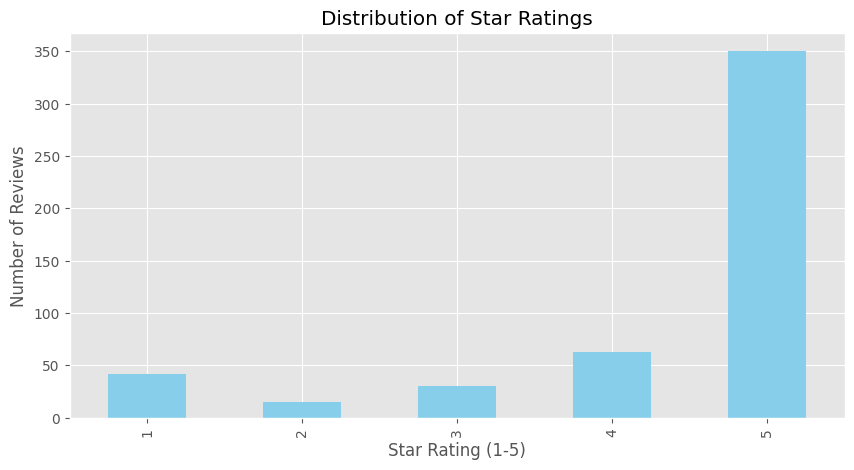

In [4]:
print("\n=== Review Distribution Analysis ===")

# Visualize star rating distribution
plt.figure(figsize=(10,5))
ax = df['Score'].value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    title='Distribution of Star Ratings'
)
ax.set_xlabel('Star Rating (1-5)')
ax.set_ylabel('Number of Reviews')
plt.show()

Insight 1: The class imbalance - most reviews are positive (4-5 stars).
This is common in review datasets and can bias sentiment analysis models toward predicting positive sentiment more frequently.

Learning Reflection: Need to consider class imbalance when interpreting results.
High accuracy might be misleading if models just predict majority class.

# Section 3: Text Processing with NLTK

In [5]:
print("\n=== Text Processing Example ===")
sample = df['Text'][10]
print("Original Text:\n", sample)


=== Text Processing Example ===
Original Text:
 I can remember buying this candy as a kid and the quality hasn't dropped in all these years. Still a superb product you won't be disappointed with.


In [6]:
# Tokenization
tokens = nltk.word_tokenize(sample)
tokens[:10]

['I', 'can', 'remember', 'buying', 'this', 'candy', 'as', 'a', 'kid', 'and']

In [7]:
# POS Tagging
tagged = nltk.pos_tag(tokens)
print("\nFirst 10 POS Tags:", tagged[:10])


First 10 POS Tags: [('I', 'PRP'), ('can', 'MD'), ('remember', 'VB'), ('buying', 'VBG'), ('this', 'DT'), ('candy', 'NN'), ('as', 'IN'), ('a', 'DT'), ('kid', 'NN'), ('and', 'CC')]


# Section 4: VADER Sentiment Analysis
We will use NLTK's Sentiment Intensity Analyzer to get the neg/neu/pos scores of the text.
This uses a "bag of words' approach
1. Stop words are removed
2. Each word is scored and combined into a total score

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
sia

In [10]:
# Testing: Example 1
sia.polarity_scores("I absolutely hate this product!")

{'neg': 0.588, 'neu': 0.412, 'pos': 0.0, 'compound': -0.6468}

In [11]:
# Testing: Example 2
sia.polarity_scores("This is fantastic, love it!")

{'neg': 0.0, 'neu': 0.27, 'pos': 0.73, 'compound': 0.8439}

In [12]:
# Testing: Mixed Text
sia.polarity_scores("The idea is good but execution is poor.")

{'neg': 0.343, 'neu': 0.496, 'pos': 0.161, 'compound': -0.4939}

### Run the polarity score on the entire dataset

In [13]:
# Calculate Scores for All Reviews
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  results[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
vader_results = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Id'})
vader_results = vader_results.merge(df, on='Id')

In [15]:
# Now we have sentiment score and metadata
vader_results.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,9,0.000,0.851,0.149,0.6369,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
4,10,0.000,0.705,0.295,0.8313,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


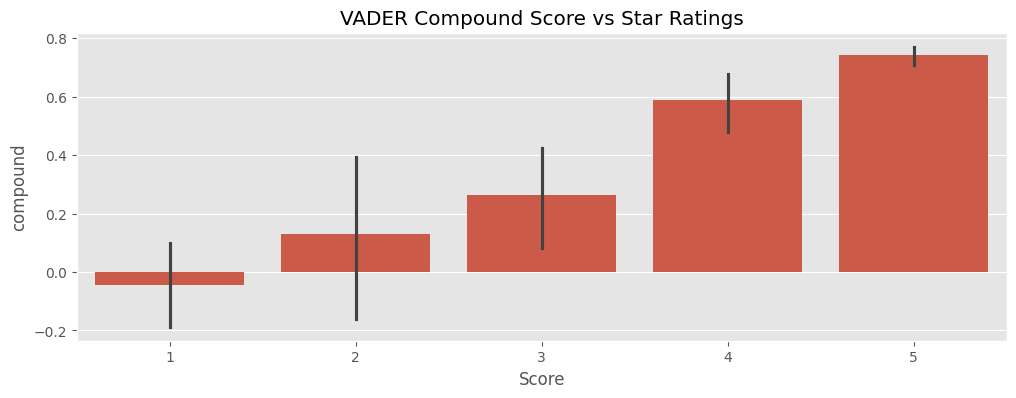

In [16]:
# Visualization: VADER Bar Plot
plt.figure(figsize=(12,4))
sns.barplot(data=vader_results, x='Score', y='compound')
plt.title('VADER Compound Score vs Star Ratings')
plt.show()


=== RoBERTa Model Implementation ===


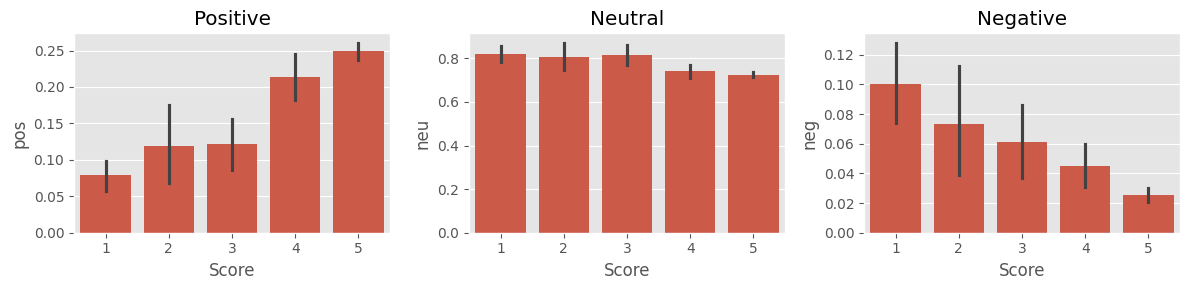

In [17]:
# Individual Sentiment Scores VS Star Ratings
print("\n=== RoBERTa Model Implementation ===")
fig, axs = plt.subplots(1,3,figsize=(12, 3))
sns.barplot(data=vader_results, x='Score', y='pos', ax = axs[0])
sns.barplot(data=vader_results, x='Score', y='neu', ax = axs[1])
sns.barplot(data=vader_results, x='Score', y='neg', ax = axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

Key Finding:
These trends indicate a strong correlation between sentiment analysis is an effective way to predict overall user satisfaction. However, sentiment scores alone might not fully capture nuanced review tones, such as sarcasm or mixed sentiments in a single review.

Learning Reflection: Further analysis (e.g., deeper text context processing) may be needed to refine sentiment classification accuracy.

## Section 5: RoBERTa Transformer Model
*   Use a model trained of large corpus of data
*   Transformer model accounts for the words but also the contect related to other words


In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [19]:
Model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(Model)
model = AutoModelForSequenceClassification.from_pretrained(Model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [20]:
# # VADER results on example
example = "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [21]:
# Run Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
score_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

print(score_dict)

{'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687465), 'roberta_pos': np.float32(0.0029573706)}


In [22]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  score_dict = {
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2]
  }
  return score_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both

  except RuntimeError:
    print(f'Broke for id {myid}')



  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
results_df = pd.DataFrame(res).T
result_df = results_df.reset_index().rename(columns={'index': 'Id'})
result_df = result_df.merge(df, how='left')

In [25]:
results_df.head()


,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,0.138,0.862,0.000,-0.5664,0.489171,0.465882,0.044946
4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
9,0.000,0.851,0.149,0.6369,0.003874,0.094156,0.901970
10,0.000,0.705,0.295,0.8313,0.003103,0.055912,0.940984


## Section 6: Compare Scores between Models

In [26]:
results_df.columns

Index(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
      dtype='object')

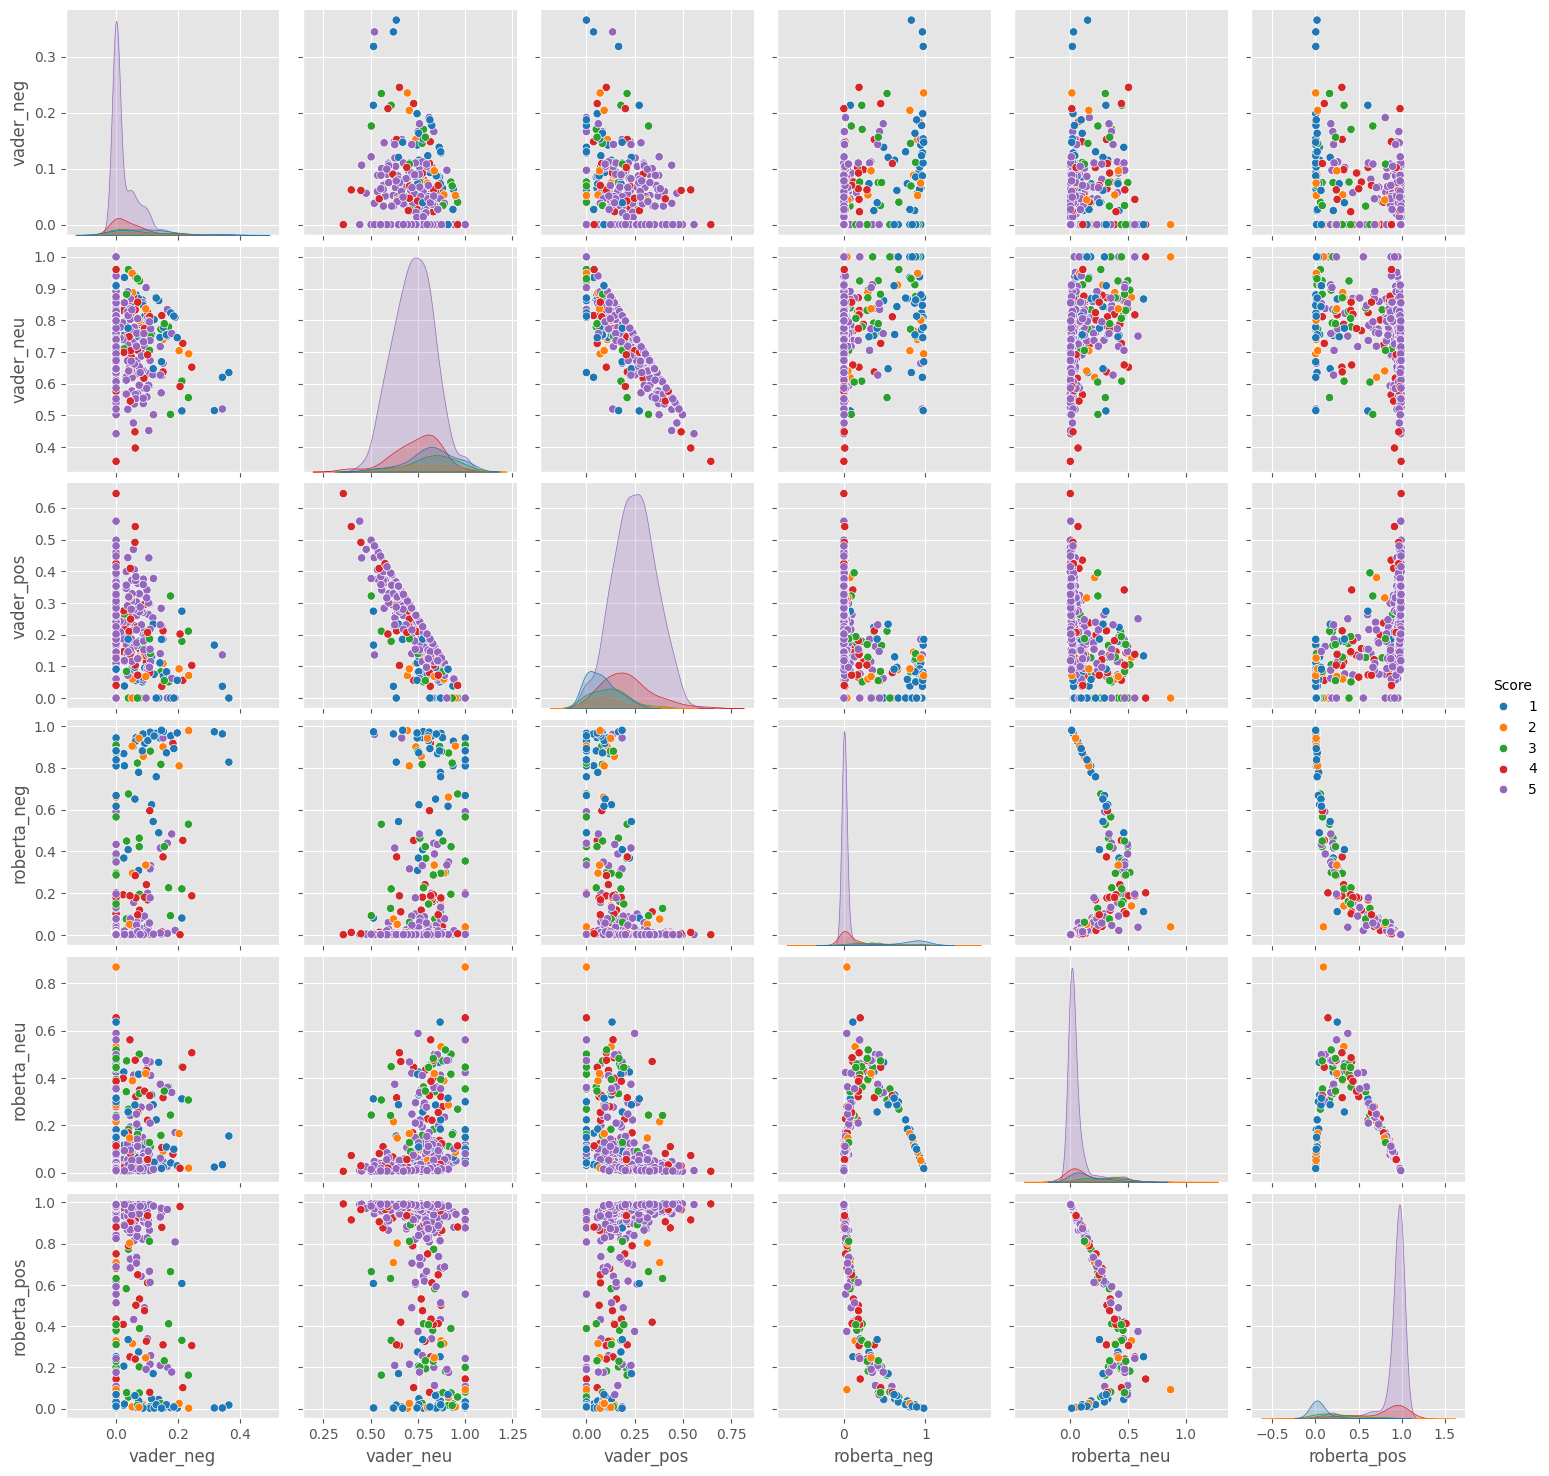

In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Pairplot: to visualize relationships between sentiment scores from VADER and RoBERTa models
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg',
                   'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()


### Key Insight:
RoBERTa shows better discrimination between neutral and polarized reviews.
VADER tends to compress scores toward extremes.

### Learning Reflection:
Model choice depends on use case - rule-based for speed,
transformers for accuracy when context matters.


## Section 7: Error Analysis


*   Positive 1-Star and Negative 5-Star Review

Let's look at some examples where the model scoring and ewview score differ the most.



In [29]:
print("\n=== Interesting Edge Cases ===")

# Positive sentiment 1-star review
negative_discrepancy = results_df.query("Score == 1")\
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]
print("\n1-Star Review with High Positive Sentiment:\n", negative_discrepancy)


=== Interesting Edge Cases ===

1-Star Review with High Positive Sentiment:
 I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months.


In [30]:
print("\n=== Interesting Edge Cases ===")

# Positive sentiment 1-star review
negative_discrepancy = results_df.query("Score == 1")\
    .sort_values('vader_pos', ascending=False)['Text'].values[0]
print("\n1-Star Review with High Positive Sentiment:\n", negative_discrepancy)


=== Interesting Edge Cases ===

1-Star Review with High Positive Sentiment:
 So we cancelled the order.  It was cancelled without any problem.  That is a positive note...


In [31]:
print("\n=== Interesting Edge Cases ===")

# Negative sentiment 5-star review
positive_discrepancy = results_df.query("Score == 5")\
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]
print("\n5-Star Review with High Negative Sentiment:\n", positive_discrepancy)


=== Interesting Edge Cases ===

5-Star Review with High Negative Sentiment:
 this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


In [32]:
print("\n=== Interesting Edge Cases ===")

# Negative sentiment 5-star review
positive_discrepancy = results_df.query("Score == 5")\
    .sort_values('vader_neg', ascending=False)['Text'].values[0]
print("\n5-Star Review with High Negative Sentiment:\n", positive_discrepancy)


=== Interesting Edge Cases ===

5-Star Review with High Negative Sentiment:
 this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


### Observation:
The above examples shows models focusing on text content rather than
real-world context.

### Learning Reflection:
Sentiment analysis alone may be insufficient for
complex customer experience analysis.


## Extra: The Transformers Pipeline
Quick and easy way to run sentiment predictions

In [33]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [34]:
sent_pipeline("I have a great day!")

[{'label': 'POSITIVE', 'score': 0.9998867511749268}]

In [35]:
sent_pipeline("It is the worst day of my life")

[{'label': 'NEGATIVE', 'score': 0.999786913394928}]

# Section 8: Learning Reflections

Final Reflections:
1. Context Matters: Transformer models better capture contextual relationships
2. Speed-Accuracy Tradeoff: VADER processes 500 reviews in seconds vs minutes for RoBERTa
3. Data Quality Issues: Found several multilingual reviews that neither model handles well
4. Deployment Challenges: Transformer models require significant resources

In [36]:
# Clean notebook metadata before export
from IPython.display import Javascript

Javascript('''
require(["base/js/namespace"], function(Jupyter) {
    Jupyter.notebook.metadata.widgets = undefined;
    Jupyter.notebook.save_checkpoint();
});
''')

<IPython.core.display.Javascript object>